In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("insiders_with_preprocessed_descriptions.csv")
descriptions = df['processed_description']
cpv_description_df = df[['CPV', 'processed_description']]

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
cpv_description_df = cpv_description_df.sort_values(by='CPV')
cpv_description_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57048 entries, 46668 to 34561
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CPV                    57048 non-null  object
 1   processed_description  57048 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [3]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(descriptions, test_size=0.25, random_state=42)

In [3]:
from torch.utils.data import DataLoader
from sentence_transformers import InputExample

pairs = []

cpv_groups = cpv_description_df.groupby('CPV')

for cpv, group in cpv_groups:
    list_of_descriptions = group['processed_description'].tolist()
    if len(descriptions) > 1:  # Ensure there are at least two descriptions to create pairs
        # Create pairs sequentially
        for i in range(0, len(list_of_descriptions) - 1, 2):
            if i + 1 < len(list_of_descriptions):
                pairs.append(InputExample(texts=[list_of_descriptions[i], list_of_descriptions[i + 1]]))
                
print(len(pairs))

# Create a DataLoader from the pairs
train_dataloader = DataLoader(pairs, shuffle=True, batch_size=16)

C:\Users\Pablo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


20503


## TF-IDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_embeddings = tfidf_vectorizer.fit_transform(descriptions)

In [10]:
tfidf_embeddings.shape

(57048, 50514)

In [11]:
# save
joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer.pkl')

['models/tfidf_vectorizer.pkl']

## Doc2Vec

In [56]:
from gensim.models.doc2vec import TaggedDocument

doc2vec_train_data = [TaggedDocument(words=desc.split(), tags=[str(i)]) for i, desc in enumerate(descriptions)]

In [57]:
from gensim.models.doc2vec import Doc2Vec

doc2vec_model = Doc2Vec(
    vector_size=300,
    window=5,
    min_count=1,
    workers=4,
    dm=1
)

doc2vec_model.build_vocab(doc2vec_train_data)
doc2vec_model.train(
    doc2vec_train_data, 
    total_examples=doc2vec_model.corpus_count, 
    epochs=30
)

evaluate

In [59]:
import collections

ranks = []
second_ranks = []

# Infer vectors for each document in the training corpus and find their ranks
for doc_id in range(len(doc2vec_train_data)):
    inferred_vector = doc2vec_model.infer_vector(doc2vec_train_data[doc_id].words)
    sims = doc2vec_model.dv.most_similar([inferred_vector], topn=len(doc2vec_model.dv))
    doc_ids = [int(id) for id, sim in sims]

    if doc_id in doc_ids:
        rank = doc_ids.index(doc_id)
        ranks.append(rank)
    else:
        ranks.append(-1)
    
    second_ranks.append(sims[1])

# Analyze the ranks
counter = collections.Counter(ranks)
print("Document ranks with respect to the training corpus:")
print(counter)

Document ranks with respect to the training corpus:
Counter({0: 47498, 1: 3398, 2: 783, 3: 326, 4: 187, 5: 144, 6: 106, 7: 85, 9: 74, 8: 71, 10: 69, 11: 64, 15: 54, 12: 51, 13: 46, 14: 40, 16: 36, 18: 34, 19: 33, 20: 31, 22: 30, 25: 30, 30: 29, 17: 28, 21: 28, 31: 26, 26: 24, 44: 24, 23: 24, 24: 23, 32: 23, 42: 23, 48: 23, 27: 21, 28: 19, 46: 19, 53: 18, 51: 18, 29: 18, 59: 18, 34: 17, 37: 17, 39: 17, 36: 17, 33: 17, 41: 16, 49: 16, 45: 16, 86: 15, 58: 14, 64: 14, 47: 14, 54: 13, 55: 13, 50: 13, 38: 12, 67: 12, 43: 12, 35: 12, 56: 12, 127: 12, 61: 11, 95: 11, 101: 11, 68: 11, 139: 11, 75: 11, 62: 11, 89: 11, 57: 11, 76: 11, 96: 11, 126: 11, 81: 10, 158: 10, 73: 10, 131: 10, 105: 10, 145: 10, 123: 10, 74: 10, 52: 10, 85: 10, 72: 10, 88: 10, 84: 10, 198: 9, 69: 9, 94: 9, 114: 9, 103: 9, 179: 9, 150: 9, 133: 9, 263: 9, 100: 9, 146: 9, 152: 9, 213: 9, 91: 8, 83: 8, 104: 8, 106: 8, 98: 8, 230: 8, 223: 8, 260: 8, 141: 8, 66: 8, 80: 8, 224: 8, 231: 8, 166: 8, 77: 8, 125: 8, 63: 8, 65: 8, 90: 

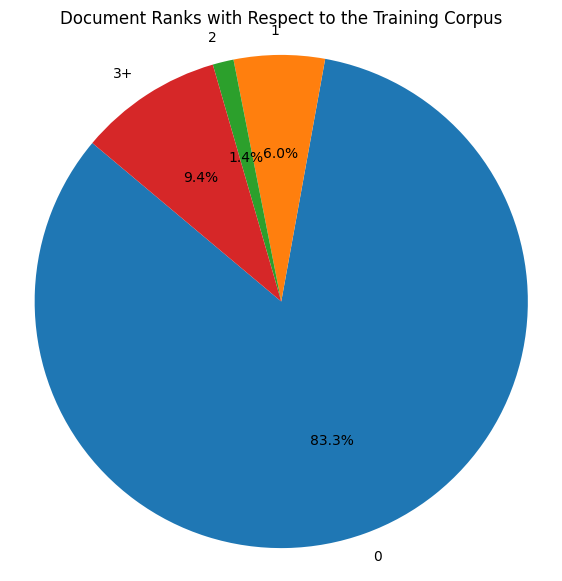

In [73]:
grouped_counter = collections.Counter()
for rank, count in counter.items():
    if rank <= 2:
        grouped_counter[rank] = count
    else:
        grouped_counter[3] += count

# Plot the distribution of document ranks as a pie chart
labels, sizes = zip(*grouped_counter.items())
labels = [str(label) if label <= 2 else '3+' for label in labels]

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Document Ranks with Respect to the Training Corpus')
plt.show()


In [75]:
# save
doc2vec_model.save('models/doc2vec_model.model')

In [74]:
doc2vec_embeddings = doc2vec_model.dv.vectors
print(len(doc2vec_embeddings), len(doc2vec_embeddings[0]))

57048 300


## RoBERTa fine-tuned

In [7]:
from sentence_transformers import SentenceTransformer, losses, models

# pre trained
word_embedding_model = models.Transformer('PlanTL-GOB-ES/roberta-base-bne')

# Load model directly
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("PlanTL-GOB-ES/roberta-base-bne")

# pool function over the token embeddings
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode='mean')
roberta_fine_tuned_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
roberta_fine_tuned_model.to(device) # gpu

train_loss = losses.MultipleNegativesRankingLoss(roberta_fine_tuned_model)
num_epochs = 5
num_warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)


roberta_fine_tuned_model.fit(train_objectives=[(train_dataloader, train_loss)], epochs = num_epochs, warmup_steps = num_warmup_steps)

C:\Users\Pablo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\Pablo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly in

In [16]:
roberta_fine_tuned_embeddings = roberta_fine_tuned_model.encode(descriptions, convert_to_tensor=True)

print(roberta_fine_tuned_embeddings.shape)

torch.Size([57048, 768])


In [8]:
# save
roberta_fine_tuned_model.save('models/roberta_fine_tuned_model')

## Sentence BERT fine-tuned

In [5]:
from sentence_transformers import SentenceTransformer, losses, models

# pre trained
sbert_fine_tuned_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
sbert_fine_tuned_model.to(device) # gpu

train_loss = losses.MultipleNegativesRankingLoss(sbert_fine_tuned_model)
num_epochs = 5
num_warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)


sbert_fine_tuned_model.fit(train_objectives=[(train_dataloader, train_loss)], epochs = num_epochs, warmup_steps = num_warmup_steps)

Epoch: 100%|██████████| 5/5 [23:45<00:00, 285.09s/it]


In [9]:
sbert_fine_tuned_embeddings = sbert_fine_tuned_model.encode(descriptions, convert_to_tensor=True)

print(sbert_fine_tuned_embeddings.shape)

torch.Size([57048, 384])


In [10]:
# save
sbert_fine_tuned_model.save('models/sbert_fine_tuned_model')